In [5]:
# First cell - Install
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN
import scipy.special

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Define the 5 Toy Datasets ---
def get_data(case_id, n_samples=1000):
    if case_id == 1:
        # f(x) = J0(20x)
        input_dim = 1
        x = torch.rand(n_samples, input_dim) * 2 - 1
        y = torch.from_numpy(scipy.special.j0(20 * x.numpy())).float()
    elif case_id == 2:
        # f(x, y) = exp(sin(pi*x) + y^2)
        input_dim = 2
        x = torch.rand(n_samples, input_dim) * 2 - 1
        term1 = torch.sin(torch.pi * x[:, [0]])
        term2 = x[:, [1]] ** 2
        y = torch.exp(term1 + term2)
    elif case_id == 3:
        # f(x, y) = xy
        input_dim = 2
        x = torch.rand(n_samples, input_dim) * 2 - 1
        y = x[:, [0]] * x[:, [1]]
    elif case_id == 4:
        # High-dim: f(x1...x100) = exp(1/100 * sum(sin^2(pi*xi/2)))
        input_dim = 100
        x = torch.rand(n_samples, input_dim) * 2 - 1
        inner = torch.sin(torch.pi * x / 2) ** 2
        mean_inner = torch.mean(inner, dim=1, keepdim=True)
        y = torch.exp(mean_inner)
    elif case_id == 5:
        # 4D: f = exp(0.5 * (sin(pi*(x1^2+x2^2)) + sin(pi*(x3^2+x4^2))))
        input_dim = 4
        x = torch.rand(n_samples, input_dim) * 2 - 1
        part1 = torch.sin(torch.pi * (x[:, 0]**2 + x[:, 1]**2))
        part2 = torch.sin(torch.pi * (x[:, 2]**2 + x[:, 3]**2))
        y = torch.exp(0.5 * (part1 + part2)).unsqueeze(1)
    
    # Move to device
    x = x.to(device)
    y = y.to(device)
    
    return x, y, input_dim

Using device: cuda


In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, width, depth):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        for _ in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(width, 1))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [8]:
def train_kan(case_id):
    """
    Reproduces the KAN training schedule:
    Grids G = {3, 5, 10, 20, 50, 100, 200}
    Train 200 steps per grid using LBFGS.
    Returns results and input_dim.
    """
    dataset = {}
    dataset['train_input'], dataset['train_label'], input_dim = get_data(case_id, n_samples=1000)
    dataset['test_input'], dataset['test_label'], _ = get_data(case_id, n_samples=1000)
    
    # Shape (kept from original)
    if case_id == 1: 
        shape = [1, 1]
    elif case_id == 2: 
        shape = [2, 1, 1]
    elif case_id == 3: 
        shape = [2, 2, 1]
    elif case_id == 4: 
        shape = [100, 1, 1]
    elif case_id == 5: 
        shape = [4, 4, 2, 1] 
    
    # Grid schedule
    grids = [3, 5, 10, 20, 50, 100]
    
    # Initialize KAN
    model = KAN(width=shape, grid=grids[0], k=3, seed=0, device=device) 
    
    results = {'params': [], 'rmse': [], 'grids': []}
    
    for g in grids:
        if g != grids[0]:
            model = model.refine(g)
        
        model.fit(dataset, opt="LBFGS", steps=200)
        
        # Parameter count (approx)
        n_params = sum(p.numel() for p in model.parameters())
        
        pred = model(dataset['test_input'])
        rmse = torch.sqrt(torch.mean((pred - dataset['test_label'])**2)).item()
        
        results['params'].append(n_params)
        results['rmse'].append(rmse)
        results['grids'].append(g)
        
        print(f"Case {case_id} | Grid {g} | Params {n_params} | Test RMSE {rmse:.2e}")
    
    return results, input_dim

def train_mlp_baseline(case_id, depths=[2, 3, 4, 5], max_params_limit=150000):
    """
    Modified to skip models with > max_params_limit parameters.
    Returns results dict keyed by depth and the input_dim.
    """
    x_train, y_train, input_dim = get_data(case_id, n_samples=1000)
    x_test, y_test, _ = get_data(case_id, n_samples=1000)
    
    results = {}
    widths = [10, 50, 100, 200, 500, 1000] 
    
    for d in depths:
        results[d] = {'params': [], 'rmse': []}
        for w in widths:
            model = SimpleMLP(input_dim, w, d).to(device)
            n_params = model.count_parameters()
            
            if n_params > max_params_limit:
                print(f"Skipping MLP Depth {d} Width {w} (Params {n_params} > {max_params_limit})")
                continue
            
            optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
            criterion = nn.MSELoss()
            
            def closure():
                optimizer.zero_grad()
                out = model(x_train)
                loss = criterion(out, y_train)
                loss.backward()
                return loss
            
            for _ in range(20): 
                optimizer.step(closure)
            
            with torch.no_grad():
                pred = model(x_test)
                rmse = torch.sqrt(criterion(pred, y_test)).item()
            
            results[d]['params'].append(n_params)
            results[d]['rmse'].append(rmse)
            print(f"MLP Depth {d} Width {w} | Params {n_params} | Test RMSE {rmse:.2e}")
    
    return results, input_dim

In [9]:
def add_theory_line(ax, params, rmse_list, alpha, label, linestyle='--', color=None, offset_factor=1.0):
    """
    Plots a theoretical scaling line y = C * x^(-alpha)
    Anchors to the first valid (p, r) pair in the given lists.
    """
    if not params or not rmse_list: 
        return
    
    # 1. Find first valid anchor point
    anchor_x = None
    anchor_y = None
    for p, r in zip(params, rmse_list):
        if np.isfinite(r) and np.isfinite(p) and p > 0:
            anchor_x = p
            anchor_y = r
            break
    
    if anchor_x is None:
        return
    
    x_min, x_max = min(params), max(params)
    x = np.logspace(np.log10(x_min*0.9), np.log10(x_max*1.1), 200)
    C = anchor_y * (anchor_x ** alpha) * offset_factor
    y = C * (x ** -alpha)
    
    # Use loglog plotting; color may be None (matplotlib chooses)
    ax.loglog(x, y, linestyle, color=color, linewidth=2.5, label=label)

def run_experiment(case_id=1):
    titles = {
        1: r'$J_0(20x)$',
        2: r'$\exp(\sin(\pi x)+y^2)$',
        3: r'$x y$',
        4: r'$\exp(\frac{1}{100}\sum \sin^2(\frac{\pi x_i}{2}))$',
        5: r'$\exp(0.5(\sin(\pi(x_1^2+x_2^2))+\sin(\pi(x_3^2+x_4^2))))$'
    }
    
    print(f"--- Running Case {case_id} ---")
    kan_res, d_kan = train_kan(case_id)
    mlp_res, d_mlp = train_mlp_baseline(case_id, max_params_limit=200000)
    
    # dimension (input dim) - both d_kan and d_mlp come from get_data and should match
    input_dim = d_kan
    
    plt.figure(figsize=(9, 7))
    ax = plt.gca()
    
    # Plot KAN
    ax.loglog(kan_res['params'], kan_res['rmse'], 'o-', 
              label='KAN', linewidth=4, markersize=10, color='#1f77b4')
    
    # Plot MLPs
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, (d, res) in enumerate(mlp_res.items()):
        if not res['params']: 
            continue
        c = colors[i % len(colors)]
        ax.loglog(res['params'], res['rmse'], 'o-', 
                  label=f'MLP (depth {d})', linewidth=2, markersize=7, color=c)
    
    # --- THEORETICAL LINES ---
    # Red: always N^{-4}, anchored to KAN first valid point
    add_theory_line(ax, kan_res['params'], kan_res['rmse'], 
                    alpha=4.0, label=r'Theory (KAN) $N^{-4}$', linestyle='--', color='red', offset_factor=1.0)
    
    # Black: N^{-4/d} where d = input_dim, anchor to deepest MLP if available else KAN
    if input_dim <= 0:
        alpha_black = 4.0
    else:
        alpha_black = 4.0 / float(input_dim)
    
    # find deepest MLP with data
    valid_mlps = [res for res in mlp_res.values() if res['params']]
    if valid_mlps:
        anchor_res = valid_mlps[-1]
        add_theory_line(ax, anchor_res['params'], anchor_res['rmse'],
                        alpha=alpha_black,
                        label=rf'Theory (ID) $N^{{-{alpha_black:.3g}}}$',
                        linestyle='--', color='black', offset_factor=1.0)
    else:
        # fallback anchor to KAN if no MLPs are available
        add_theory_line(ax, kan_res['params'], kan_res['rmse'],
                        alpha=alpha_black,
                        label=rf'Theory (ID) $N^{{-{alpha_black:.3g}}}$',
                        linestyle='--', color='black', offset_factor=1.0)
    
    plt.xlabel('Number of parameters', fontsize=16)
    plt.ylabel('Test RMSE', fontsize=16)
    plt.title(f'f(x) = {titles.get(case_id, f"Case {case_id}")}', fontsize=18)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    plt.tight_layout()
    plt.show()

In [10]:
def run_experiment(case_id=1):
    titles = {
        1: r'$J_0(20x)$',
        2: r'$\exp(\sin(\pi x)+y^2)$',
        3: r'$x y$',
        4: r'$\exp(\frac{1}{100}\sum \sin^2(\frac{\pi x_i}{2}))$',
        5: r'$\exp(0.5(\sin(\pi(x_1^2+x_2^2))+\sin(\pi(x_3^2+x_4^2))))$'
    }
    print(f"--- Running Case {case_id} ---")
    
    kan_res, d_kan = train_kan(case_id)
    mlp_res, d_mlp = train_mlp_baseline(case_id, max_params_limit=200000)
    
    # dimension (input dim) - both d_kan and d_mlp come from get_data and should match
    input_dim = d_kan

    plt.figure(figsize=(9, 7))
    ax = plt.gca()
    
    # Plot KAN
    ax.loglog(kan_res['params'], kan_res['rmse'], 'o-', 
               label='KAN', linewidth=4, markersize=10, color='#1f77b4')
    
    # Plot MLPs
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, (d, res) in enumerate(mlp_res.items()):
        if not res['params']: continue
        c = colors[i % len(colors)]
        ax.loglog(res['params'], res['rmse'], 'o-', 
                   label=f'MLP (depth {d})', linewidth=2, markersize=7, color=c)
        
    # --- THEORETICAL LINES ---
    # Red: always N^{-4}, anchored to KAN first valid point
    add_theory_line(ax, kan_res['params'], kan_res['rmse'], 
                    alpha=4.0, label=r'Theory (KAN) $N^{-4}$', linestyle='--', color='red', offset_factor=1.0)
    
    # Black: N^{-4/d} where d = input_dim, anchor to deepest MLP if available else KAN
    if input_dim <= 0:
        alpha_black = 4.0
    else:
        alpha_black = 4.0 / float(input_dim)
    # find deepest MLP with data
    valid_mlps = [res for res in mlp_res.values() if res['params']]
    if valid_mlps:
        anchor_res = valid_mlps[-1]
        add_theory_line(ax, anchor_res['params'], anchor_res['rmse'],
                        alpha=alpha_black,
                        label=rf'Theory (ID) $N^{{-{alpha_black:.3g}}}$',
                        linestyle='--', color='black', offset_factor=1.0)
    else:
        # fallback anchor to KAN if no MLPs are available
        add_theory_line(ax, kan_res['params'], kan_res['rmse'],
                        alpha=alpha_black,
                        label=rf'Theory (ID) $N^{{-{alpha_black:.3g}}}$',
                        linestyle='--', color='black', offset_factor=1.0)
    
    plt.xlabel('Number of parameters', fontsize=16)
    plt.ylabel('Test RMSE', fontsize=16)
    plt.title(f'f(x) = {titles.get(case_id, f"Case {case_id}")}', fontsize=18)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    plt.tight_layout()
    plt.show()

--- Running Case 2 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-02 | test_loss: 1.82e-02 | reg: 1.14e+01 | : 100%|█| 200/200 [00:16<00:00, 12.19


saving model version 0.1
Case 2 | Grid 3 | Params 80 | Test RMSE 1.82e-02
saving model version 0.2


| train_loss: 6.62e-03 | test_loss: 7.29e-03 | reg: 1.14e+01 | : 100%|█| 200/200 [00:12<00:00, 15.62


saving model version 0.3
Case 2 | Grid 5 | Params 92 | Test RMSE 7.29e-03
saving model version 0.4


| train_loss: 4.10e-04 | test_loss: 4.36e-04 | reg: 1.14e+01 | : 100%|█| 200/200 [00:14<00:00, 13.64


saving model version 0.5
Case 2 | Grid 10 | Params 122 | Test RMSE 4.36e-04
saving model version 0.6


| train_loss: 1.16e-04 | test_loss: 1.41e-04 | reg: 1.14e+01 | : 100%|█| 200/200 [00:11<00:00, 17.06


saving model version 0.7
Case 2 | Grid 20 | Params 182 | Test RMSE 1.41e-04
saving model version 0.8


| train_loss: 4.24e-05 | test_loss: 5.57e-05 | reg: 1.14e+01 | : 100%|█| 200/200 [00:10<00:00, 18.31


saving model version 0.9
Case 2 | Grid 50 | Params 362 | Test RMSE 5.57e-05
saving model version 0.10


| train_loss: 4.25e-05 | test_loss: 1.14e-04 | reg: 1.14e+01 | : 100%|█| 200/200 [00:09<00:00, 21.88


saving model version 0.11
Case 2 | Grid 100 | Params 662 | Test RMSE 1.14e-04
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.16e-01
MLP Depth 2 Width 50 | Params 201 | Test RMSE 6.63e-02
MLP Depth 2 Width 100 | Params 401 | Test RMSE 3.59e-02
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.74e-02
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.02e-02
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 8.08e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 6.26e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 1.87e-02
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.35e-02
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.03e-02
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 6.57e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 1.82e-02
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.64e-02
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.34e-02
Skipping MLP Depth

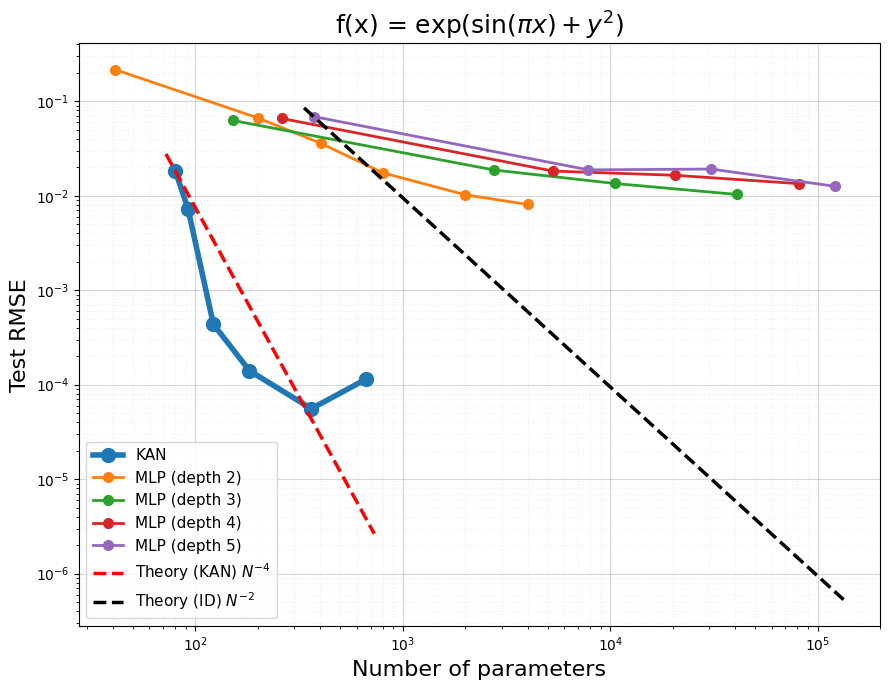

In [24]:
run_experiment(case_id=2)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.33e-04 | test_loss: 1.06e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:35<00:00,  5.62


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 1.06e-03
saving model version 0.2


| train_loss: 4.13e-04 | test_loss: 4.91e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:15<00:00, 12.91


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 4.91e-04
saving model version 0.4


| train_loss: 1.98e-04 | test_loss: 2.25e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:16<00:00, 12.05


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 2.25e-04
saving model version 0.6


| train_loss: 9.88e-05 | test_loss: 2.51e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:16<00:00, 12.24


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 2.51e-04
saving model version 0.8


| train_loss: 5.28e-05 | test_loss: 3.32e-03 | reg: 1.52e+01 | : 100%|█| 200/200 [00:18<00:00, 10.63


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 3.32e-03
saving model version 0.10


| train_loss: 7.32e-05 | test_loss: 2.61e-02 | reg: 1.53e+01 | : 100%|█| 200/200 [00:21<00:00,  9.33


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 2.61e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

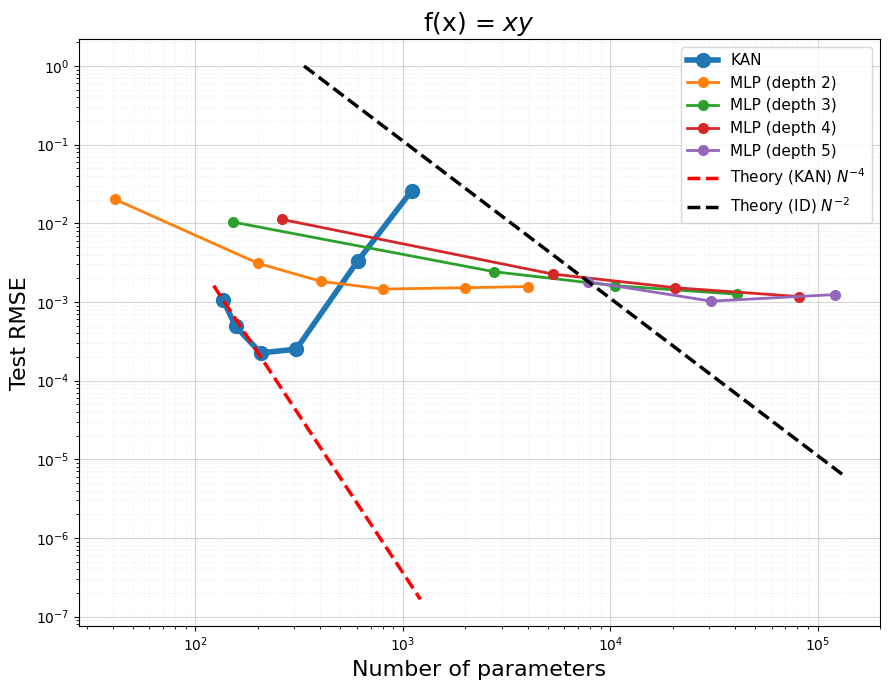

In [30]:
run_experiment(case_id=3)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.15e-03 | test_loss: 1.22e-03 | reg: 1.64e+01 | : 100%|█| 200/200 [00:26<00:00,  7.45


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 1.22e-03
saving model version 0.2


| train_loss: 7.31e-04 | test_loss: 7.74e-04 | reg: 1.63e+01 | : 100%|█| 200/200 [00:18<00:00, 10.80


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 7.74e-04
saving model version 0.4


| train_loss: 2.68e-04 | test_loss: 3.10e-04 | reg: 1.63e+01 | : 100%|█| 200/200 [00:18<00:00, 10.63


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 3.10e-04
saving model version 0.6


| train_loss: 2.25e-04 | test_loss: 5.86e-04 | reg: 1.63e+01 | : 100%|█| 200/200 [00:11<00:00, 17.82


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 5.86e-04
saving model version 0.8


| train_loss: 1.85e-04 | test_loss: 8.03e-03 | reg: 1.63e+01 | : 100%|█| 200/200 [00:16<00:00, 12.15


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 8.03e-03
saving model version 0.10


| train_loss: 1.42e-04 | test_loss: 2.73e-02 | reg: 1.61e+01 | : 100%|█| 200/200 [00:21<00:00,  9.36


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 2.73e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

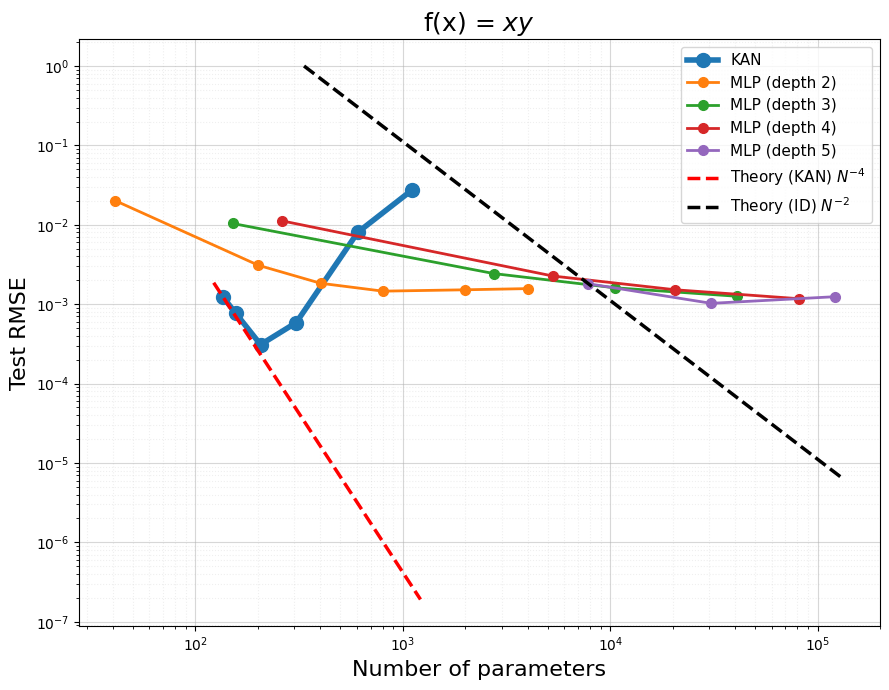

In [42]:
run_experiment(case_id=3)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.33e-04 | test_loss: 1.06e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:35<00:00,  5.61


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 1.06e-03
saving model version 0.2


| train_loss: 4.13e-04 | test_loss: 4.91e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:15<00:00, 12.92


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 4.91e-04
saving model version 0.4


| train_loss: 1.98e-04 | test_loss: 2.25e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:16<00:00, 12.04


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 2.25e-04
saving model version 0.6


| train_loss: 9.88e-05 | test_loss: 2.51e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:16<00:00, 12.28


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 2.51e-04
saving model version 0.8


| train_loss: 5.28e-05 | test_loss: 3.32e-03 | reg: 1.52e+01 | : 100%|█| 200/200 [00:18<00:00, 10.59


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 3.32e-03
saving model version 0.10


| train_loss: 7.32e-05 | test_loss: 2.61e-02 | reg: 1.53e+01 | : 100%|█| 200/200 [00:21<00:00,  9.38


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 2.61e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

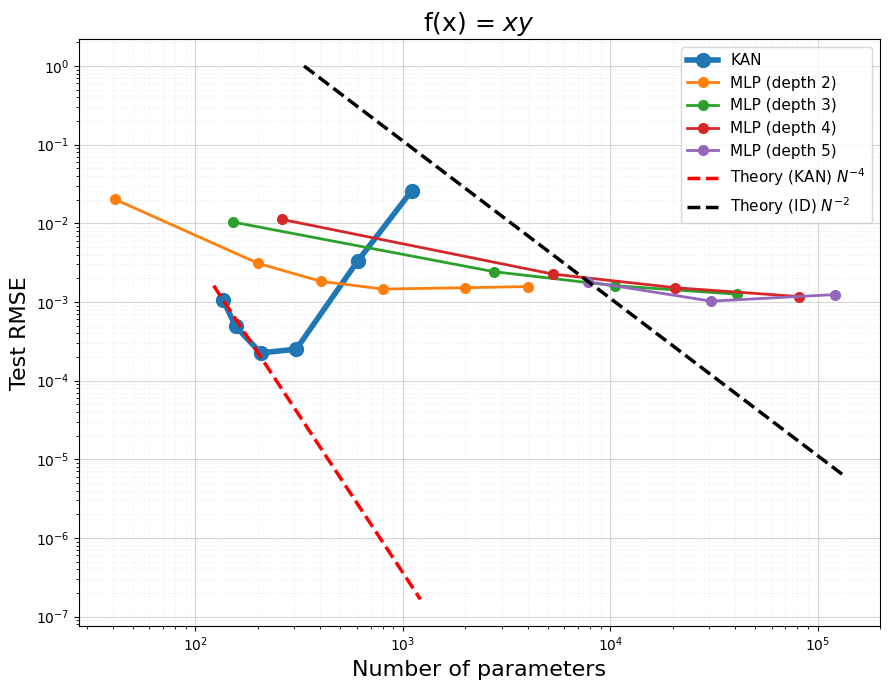

In [43]:
run_experiment(case_id=3)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-03 | test_loss: 1.31e-03 | reg: 1.43e+01 | : 100%|█| 200/200 [00:27<00:00,  7.20


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 1.31e-03
saving model version 0.2


| train_loss: 6.66e-04 | test_loss: 8.05e-04 | reg: 1.45e+01 | : 100%|█| 200/200 [00:21<00:00,  9.13


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 8.05e-04
saving model version 0.4


| train_loss: 1.90e-04 | test_loss: 2.19e-04 | reg: 1.46e+01 | : 100%|█| 200/200 [00:18<00:00, 11.02


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 2.19e-04
saving model version 0.6


| train_loss: 1.51e-04 | test_loss: 2.16e-04 | reg: 1.46e+01 | : 100%|█| 200/200 [00:11<00:00, 18.10


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 2.16e-04
saving model version 0.8


| train_loss: 1.22e-04 | test_loss: 1.45e-03 | reg: 1.46e+01 | : 100%|█| 200/200 [00:13<00:00, 14.85


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 1.45e-03
saving model version 0.10


| train_loss: 8.90e-05 | test_loss: 1.07e-02 | reg: 1.47e+01 | : 100%|█| 200/200 [00:17<00:00, 11.27


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 1.07e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

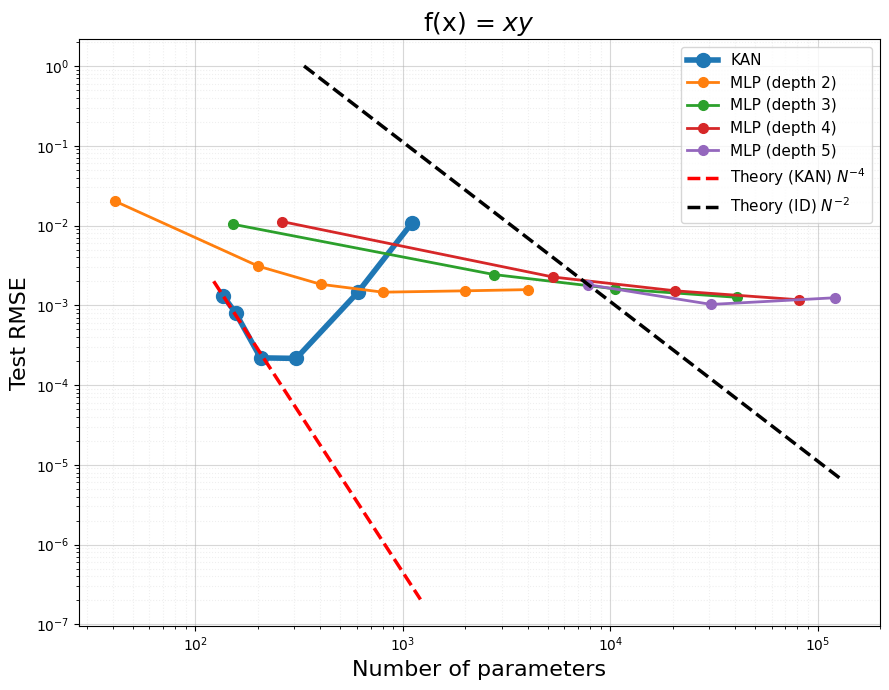

In [44]:
run_experiment(case_id=3)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.33e-04 | test_loss: 1.06e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:35<00:00,  5.63


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 1.06e-03
saving model version 0.2


| train_loss: 4.13e-04 | test_loss: 4.91e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:15<00:00, 12.90


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 4.91e-04
saving model version 0.4


| train_loss: 1.98e-04 | test_loss: 2.25e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:16<00:00, 12.04


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 2.25e-04
saving model version 0.6


| train_loss: 9.88e-05 | test_loss: 2.51e-04 | reg: 1.52e+01 | : 100%|█| 200/200 [00:16<00:00, 12.23


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 2.51e-04
saving model version 0.8


| train_loss: 5.28e-05 | test_loss: 3.32e-03 | reg: 1.52e+01 | : 100%|█| 200/200 [00:18<00:00, 10.65


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 3.32e-03
saving model version 0.10


| train_loss: 7.32e-05 | test_loss: 2.61e-02 | reg: 1.53e+01 | : 100%|█| 200/200 [00:21<00:00,  9.33


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 2.61e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

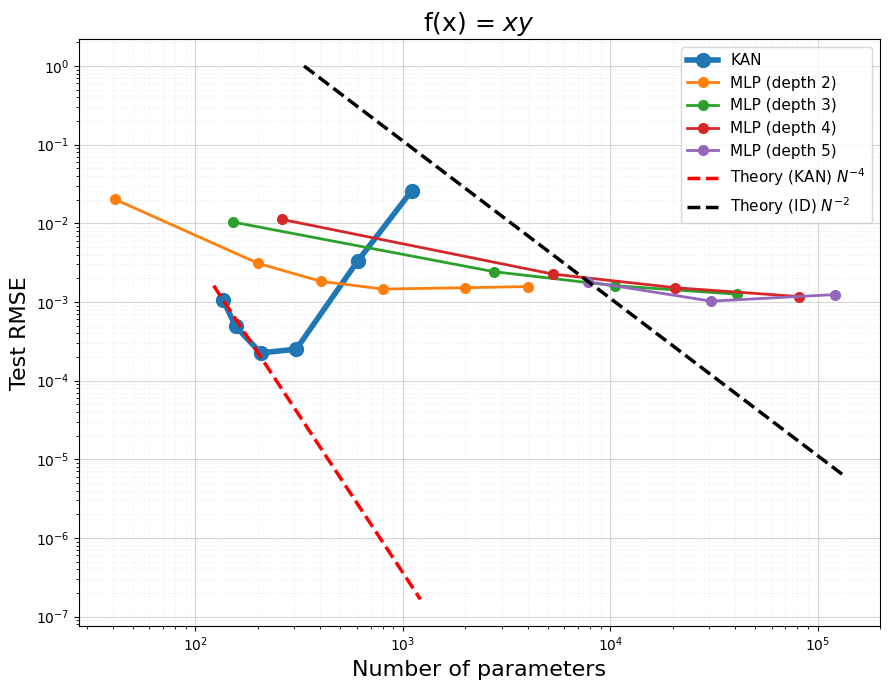

In [45]:
run_experiment(case_id=3)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.75e-04 | test_loss: 8.90e-04 | reg: 1.39e+01 | : 100%|█| 200/200 [00:36<00:00,  5.49


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 8.90e-04
saving model version 0.2


| train_loss: 3.40e-04 | test_loss: 4.04e-04 | reg: 1.39e+01 | : 100%|█| 200/200 [00:18<00:00, 10.89


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 4.04e-04
saving model version 0.4


| train_loss: 1.39e-04 | test_loss: 1.69e-04 | reg: 1.40e+01 | : 100%|█| 200/200 [00:14<00:00, 13.41


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 1.69e-04
saving model version 0.6


| train_loss: 7.82e-05 | test_loss: 5.14e-04 | reg: 1.40e+01 | : 100%|█| 200/200 [00:14<00:00, 13.95


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 5.14e-04
saving model version 0.8


| train_loss: 7.51e-05 | test_loss: 8.67e-03 | reg: 1.38e+01 | : 100%|█| 200/200 [00:19<00:00, 10.37


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 8.67e-03
saving model version 0.10


| train_loss: 8.86e-05 | test_loss: 3.50e-02 | reg: 1.38e+01 | : 100%|█| 200/200 [00:24<00:00,  8.22


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 3.50e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

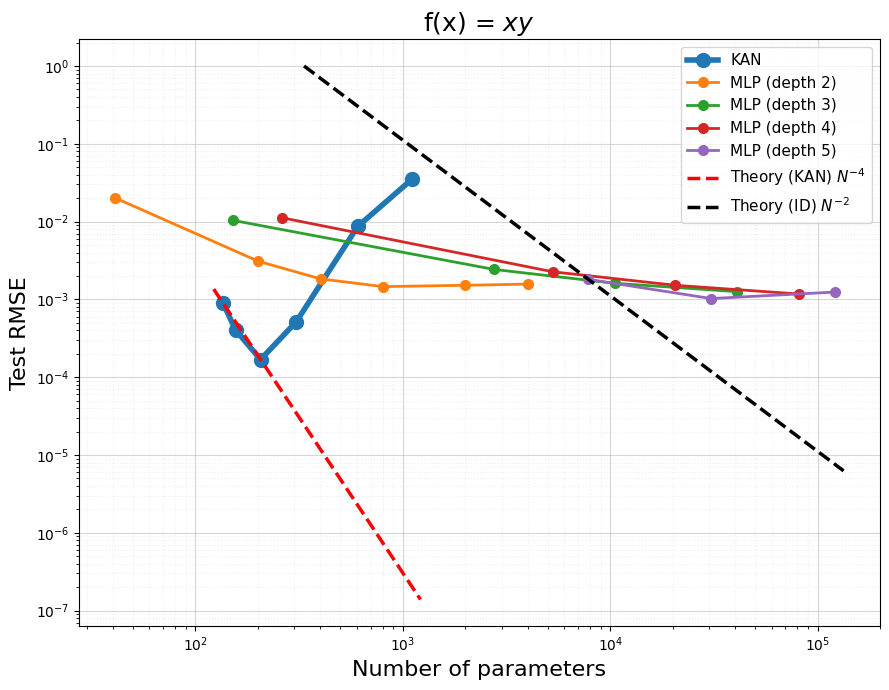

In [46]:
run_experiment(case_id=3)

--- Running Case 3 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-03 | test_loss: 1.31e-03 | reg: 1.43e+01 | : 100%|█| 200/200 [00:27<00:00,  7.21


saving model version 0.1
Case 3 | Grid 3 | Params 136 | Test RMSE 1.31e-03
saving model version 0.2


| train_loss: 6.66e-04 | test_loss: 8.05e-04 | reg: 1.45e+01 | : 100%|█| 200/200 [00:21<00:00,  9.13


saving model version 0.3
Case 3 | Grid 5 | Params 156 | Test RMSE 8.05e-04
saving model version 0.4


| train_loss: 1.90e-04 | test_loss: 2.19e-04 | reg: 1.46e+01 | : 100%|█| 200/200 [00:18<00:00, 11.05


saving model version 0.5
Case 3 | Grid 10 | Params 206 | Test RMSE 2.19e-04
saving model version 0.6


| train_loss: 1.51e-04 | test_loss: 2.16e-04 | reg: 1.46e+01 | : 100%|█| 200/200 [00:11<00:00, 18.12


saving model version 0.7
Case 3 | Grid 20 | Params 306 | Test RMSE 2.16e-04
saving model version 0.8


| train_loss: 1.22e-04 | test_loss: 1.45e-03 | reg: 1.46e+01 | : 100%|█| 200/200 [00:13<00:00, 14.91


saving model version 0.9
Case 3 | Grid 50 | Params 606 | Test RMSE 1.45e-03
saving model version 0.10


| train_loss: 8.90e-05 | test_loss: 1.07e-02 | reg: 1.47e+01 | : 100%|█| 200/200 [00:17<00:00, 11.26


saving model version 0.11
Case 3 | Grid 100 | Params 1106 | Test RMSE 1.07e-02
MLP Depth 2 Width 10 | Params 41 | Test RMSE 2.01e-02
MLP Depth 2 Width 50 | Params 201 | Test RMSE 3.09e-03
MLP Depth 2 Width 100 | Params 401 | Test RMSE 1.83e-03
MLP Depth 2 Width 200 | Params 801 | Test RMSE 1.46e-03
MLP Depth 2 Width 500 | Params 2001 | Test RMSE 1.52e-03
MLP Depth 2 Width 1000 | Params 4001 | Test RMSE 1.57e-03
MLP Depth 3 Width 10 | Params 151 | Test RMSE 1.04e-02
MLP Depth 3 Width 50 | Params 2751 | Test RMSE 2.43e-03
MLP Depth 3 Width 100 | Params 10501 | Test RMSE 1.61e-03
MLP Depth 3 Width 200 | Params 41001 | Test RMSE 1.26e-03
Skipping MLP Depth 3 Width 500 (Params 252501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1005001 > 200000)
MLP Depth 4 Width 10 | Params 261 | Test RMSE 1.12e-02
MLP Depth 4 Width 50 | Params 5301 | Test RMSE 2.26e-03
MLP Depth 4 Width 100 | Params 20601 | Test RMSE 1.52e-03
MLP Depth 4 Width 200 | Params 81201 | Test RMSE 1.17e-03
Skipping MLP Dept

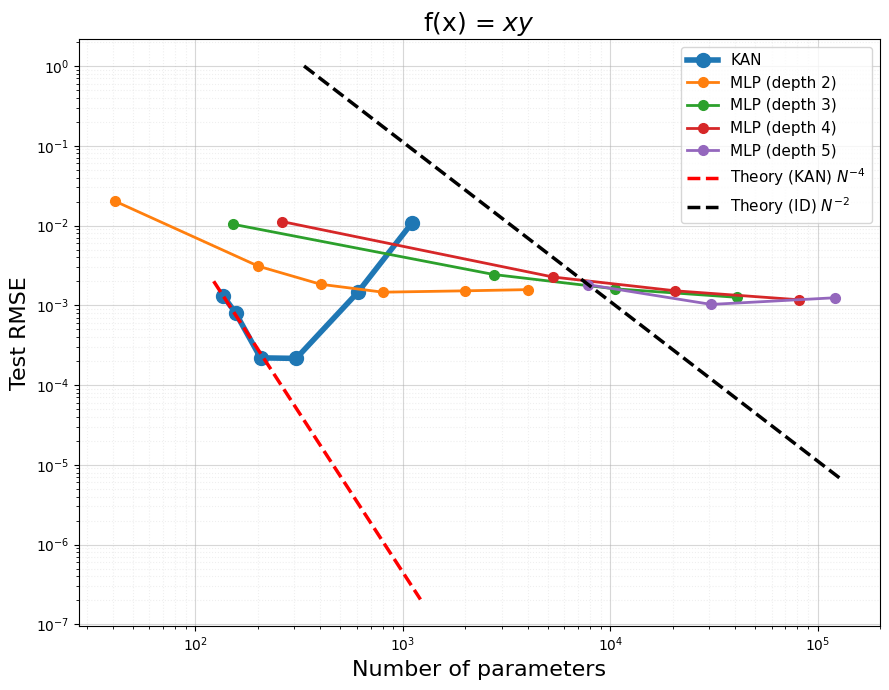

In [47]:
run_experiment(case_id=3)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.52e-02 | test_loss: 1.11e-01 | reg: 2.41e+01 | : 100%|█| 200/200 [00:39<00:00,  5.09


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 1.11e-01
saving model version 0.2


| train_loss: 1.68e-02 | test_loss: 1.94e-01 | reg: 2.72e+01 | : 100%|█| 200/200 [00:39<00:00,  5.07


saving model version 0.3
Case 4 | Grid 5 | Params 2836 | Test RMSE 1.94e-01
saving model version 0.4


| train_loss: 8.47e-04 | test_loss: 5.76e-01 | reg: 2.85e+01 | : 100%|█| 200/200 [00:40<00:00,  4.94


saving model version 0.5
Case 4 | Grid 10 | Params 3846 | Test RMSE 5.76e-01
saving model version 0.6


| train_loss: 1.49e-05 | test_loss: 8.12e-01 | reg: 2.86e+01 | : 100%|█| 200/200 [00:28<00:00,  7.02


saving model version 0.7
Case 4 | Grid 20 | Params 5866 | Test RMSE 8.12e-01
saving model version 0.8


| train_loss: 1.01e-05 | test_loss: 8.24e-01 | reg: 2.85e+01 | : 100%|█| 200/200 [00:22<00:00,  8.95


saving model version 0.9
Case 4 | Grid 50 | Params 11926 | Test RMSE 8.24e-01
saving model version 0.10


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [00:59<00:00,  3.38it/s]


saving model version 0.11
Case 4 | Grid 100 | Params 22026 | Test RMSE nan
MLP Depth 2 Width 10 | Params 1021 | Test RMSE 1.04e-01
MLP Depth 2 Width 50 | Params 5101 | Test RMSE 6.76e-02
MLP Depth 2 Width 100 | Params 10201 | Test RMSE 6.09e-02
MLP Depth 2 Width 200 | Params 20401 | Test RMSE 6.06e-02
MLP Depth 2 Width 500 | Params 51001 | Test RMSE 5.50e-02
MLP Depth 2 Width 1000 | Params 102001 | Test RMSE 5.62e-02
MLP Depth 3 Width 10 | Params 1131 | Test RMSE 1.15e-01
MLP Depth 3 Width 50 | Params 7651 | Test RMSE 6.37e-02
MLP Depth 3 Width 100 | Params 20301 | Test RMSE 5.97e-02
MLP Depth 3 Width 200 | Params 60601 | Test RMSE 5.51e-02
Skipping MLP Depth 3 Width 500 (Params 301501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1103001 > 200000)
MLP Depth 4 Width 10 | Params 1241 | Test RMSE 1.15e-01
MLP Depth 4 Width 50 | Params 10201 | Test RMSE 6.62e-02
MLP Depth 4 Width 100 | Params 30401 | Test RMSE 5.84e-02
MLP Depth 4 Width 200 | Params 100801 | Test RMSE 5.62e-02
Skippin

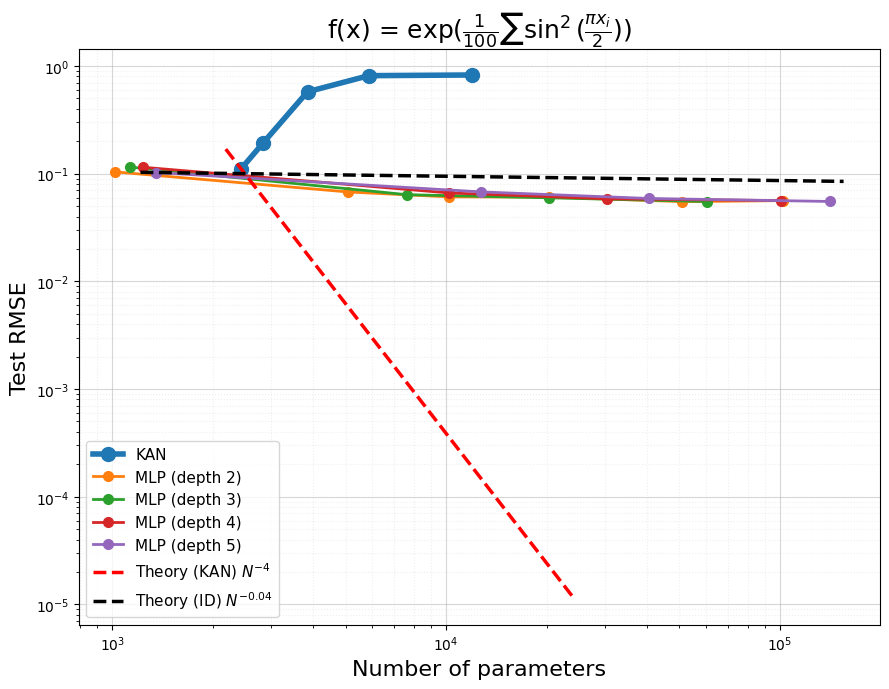

In [39]:
run_experiment(case_id=4)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.65e-02 | test_loss: 1.22e-01 | reg: 1.84e+01 | : 100%|█| 200/200 [00:39<00:00,  5.08


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 1.22e-01
saving model version 0.2


| train_loss: 1.57e-02 | test_loss: 1.39e-01 | reg: 1.74e+01 | : 100%|█| 200/200 [00:39<00:00,  5.06


saving model version 0.3
Case 4 | Grid 5 | Params 2836 | Test RMSE 1.39e-01
saving model version 0.4


| train_loss: 1.02e-04 | test_loss: 2.00e-01 | reg: 1.84e+01 | : 100%|█| 200/200 [00:40<00:00,  4.98


saving model version 0.5
Case 4 | Grid 10 | Params 3846 | Test RMSE 2.00e-01
saving model version 0.6


| train_loss: 2.71e-06 | test_loss: 2.56e-01 | reg: 1.85e+01 | : 100%|█| 200/200 [00:16<00:00, 11.82


saving model version 0.7
Case 4 | Grid 20 | Params 5866 | Test RMSE 2.56e-01
saving model version 0.8


| train_loss: 1.46e-06 | test_loss: 2.85e-01 | reg: 1.84e+01 | : 100%|█| 200/200 [00:15<00:00, 13.02


saving model version 0.9
Case 4 | Grid 50 | Params 11926 | Test RMSE 2.85e-01
saving model version 0.10


| train_loss: 4.27e-06 | test_loss: 3.08e-01 | reg: 1.84e+01 | : 100%|█| 200/200 [00:29<00:00,  6.87


saving model version 0.11
Case 4 | Grid 100 | Params 22026 | Test RMSE 3.08e-01
MLP Depth 2 Width 10 | Params 1021 | Test RMSE 1.04e-01
MLP Depth 2 Width 50 | Params 5101 | Test RMSE 6.76e-02
MLP Depth 2 Width 100 | Params 10201 | Test RMSE 6.09e-02
MLP Depth 2 Width 200 | Params 20401 | Test RMSE 6.06e-02
MLP Depth 2 Width 500 | Params 51001 | Test RMSE 5.50e-02
MLP Depth 2 Width 1000 | Params 102001 | Test RMSE 5.62e-02
MLP Depth 3 Width 10 | Params 1131 | Test RMSE 1.15e-01
MLP Depth 3 Width 50 | Params 7651 | Test RMSE 6.37e-02
MLP Depth 3 Width 100 | Params 20301 | Test RMSE 5.97e-02
MLP Depth 3 Width 200 | Params 60601 | Test RMSE 5.51e-02
Skipping MLP Depth 3 Width 500 (Params 301501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1103001 > 200000)
MLP Depth 4 Width 10 | Params 1241 | Test RMSE 1.15e-01
MLP Depth 4 Width 50 | Params 10201 | Test RMSE 6.62e-02
MLP Depth 4 Width 100 | Params 30401 | Test RMSE 5.84e-02
MLP Depth 4 Width 200 | Params 100801 | Test RMSE 5.62e-02
Sk

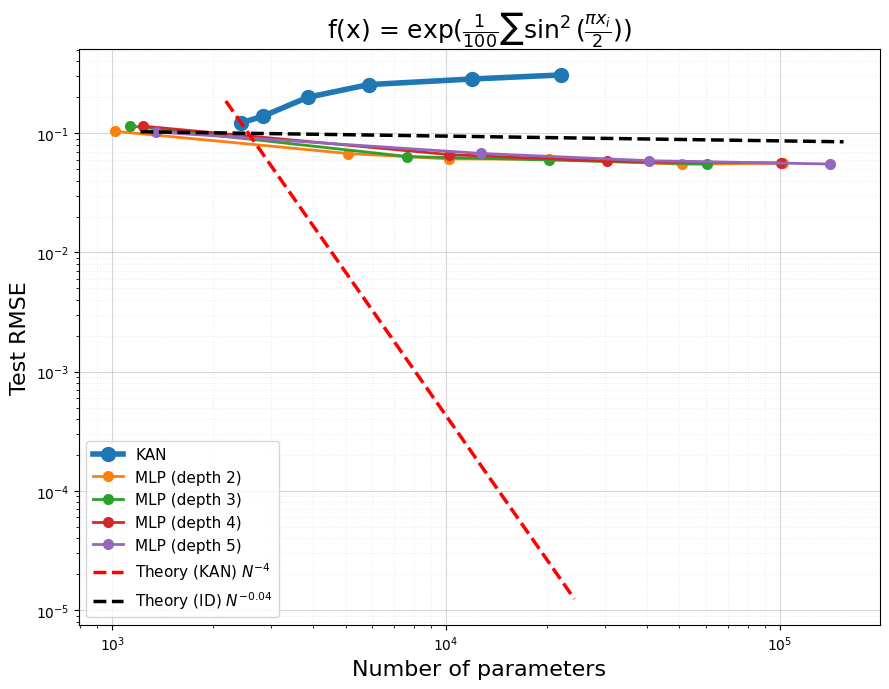

In [40]:
run_experiment(case_id=4)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.99e-02 | test_loss: 2.22e-01 | reg: 1.94e+01 | : 100%|█| 200/200 [00:47<00:00,  4.20


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 2.22e-01
saving model version 0.2


| train_loss: 1.80e-02 | test_loss: 1.37e-01 | reg: 2.04e+01 | : 100%|█| 200/200 [00:44<00:00,  4.47


saving model version 0.3
Case 4 | Grid 5 | Params 2836 | Test RMSE 1.37e-01
saving model version 0.4


| train_loss: 5.11e-04 | test_loss: 1.66e-01 | reg: 2.06e+01 | : 100%|█| 200/200 [00:45<00:00,  4.43


saving model version 0.5
Case 4 | Grid 10 | Params 3846 | Test RMSE 1.66e-01
saving model version 0.6


| train_loss: 1.16e-04 | test_loss: 2.39e-01 | reg: 2.06e+01 | : 100%|█| 200/200 [00:20<00:00,  9.89


saving model version 0.7
Case 4 | Grid 20 | Params 5866 | Test RMSE 2.39e-01
saving model version 0.8


| train_loss: 6.92e-06 | test_loss: 3.21e-01 | reg: 2.07e+01 | : 100%|█| 200/200 [00:29<00:00,  6.74


saving model version 0.9
Case 4 | Grid 50 | Params 11926 | Test RMSE 3.21e-01
saving model version 0.10


| train_loss: 5.38e-03 | test_loss: 4.15e-01 | reg: 2.07e+01 | : 100%|█| 200/200 [01:00<00:00,  3.32


saving model version 0.11
Case 4 | Grid 100 | Params 22026 | Test RMSE 4.15e-01
MLP Depth 2 Width 10 | Params 1021 | Test RMSE 1.04e-01
MLP Depth 2 Width 50 | Params 5101 | Test RMSE 6.76e-02
MLP Depth 2 Width 100 | Params 10201 | Test RMSE 6.09e-02
MLP Depth 2 Width 200 | Params 20401 | Test RMSE 6.06e-02
MLP Depth 2 Width 500 | Params 51001 | Test RMSE 5.50e-02
MLP Depth 2 Width 1000 | Params 102001 | Test RMSE 5.62e-02
MLP Depth 3 Width 10 | Params 1131 | Test RMSE 1.15e-01
MLP Depth 3 Width 50 | Params 7651 | Test RMSE 6.37e-02
MLP Depth 3 Width 100 | Params 20301 | Test RMSE 5.97e-02
MLP Depth 3 Width 200 | Params 60601 | Test RMSE 5.51e-02
Skipping MLP Depth 3 Width 500 (Params 301501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1103001 > 200000)
MLP Depth 4 Width 10 | Params 1241 | Test RMSE 1.15e-01
MLP Depth 4 Width 50 | Params 10201 | Test RMSE 6.62e-02
MLP Depth 4 Width 100 | Params 30401 | Test RMSE 5.84e-02
MLP Depth 4 Width 200 | Params 100801 | Test RMSE 5.62e-02
Sk

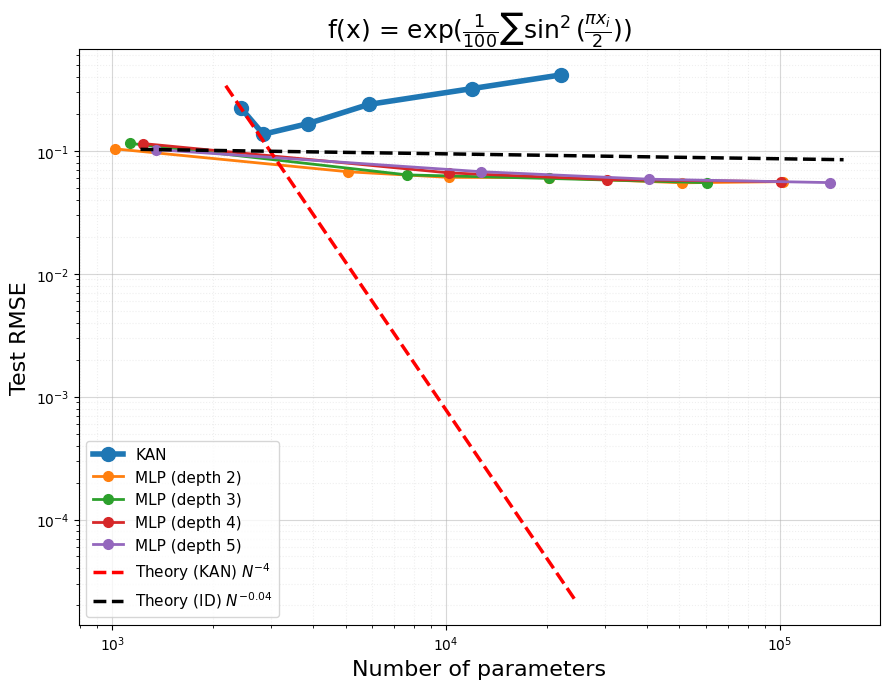

In [11]:
run_experiment(case_id=4)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-02 | test_loss: 1.55e-01 | reg: 1.66e+01 | : 100%|█| 200/200 [00:43<00:00,  4.56


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 1.55e-01
saving model version 0.2


| train_loss: 1.79e-02 | test_loss: 1.37e-01 | reg: 1.60e+01 | : 100%|█| 200/200 [00:44<00:00,  4.49


saving model version 0.3
Case 4 | Grid 5 | Params 2836 | Test RMSE 1.37e-01
saving model version 0.4


| train_loss: 2.77e-04 | test_loss: 2.71e-01 | reg: 1.67e+01 | : 100%|█| 200/200 [00:45<00:00,  4.39


saving model version 0.5
Case 4 | Grid 10 | Params 3846 | Test RMSE 2.71e-01
saving model version 0.6


| train_loss: 2.03e-06 | test_loss: 2.79e-01 | reg: 1.65e+01 | : 100%|█| 200/200 [00:20<00:00,  9.78


saving model version 0.7
Case 4 | Grid 20 | Params 5866 | Test RMSE 2.79e-01
saving model version 0.8


| train_loss: 6.53e-07 | test_loss: 3.21e-01 | reg: 1.65e+01 | : 100%|█| 200/200 [00:17<00:00, 11.72


saving model version 0.9
Case 4 | Grid 50 | Params 11926 | Test RMSE 3.21e-01
saving model version 0.10


| train_loss: 2.64e-06 | test_loss: 3.42e-01 | reg: 1.64e+01 | : 100%|█| 200/200 [00:28<00:00,  7.09


saving model version 0.11
Case 4 | Grid 100 | Params 22026 | Test RMSE 3.42e-01
MLP Depth 2 Width 10 | Params 1021 | Test RMSE 1.04e-01
MLP Depth 2 Width 50 | Params 5101 | Test RMSE 6.76e-02
MLP Depth 2 Width 100 | Params 10201 | Test RMSE 6.09e-02
MLP Depth 2 Width 200 | Params 20401 | Test RMSE 6.06e-02
MLP Depth 2 Width 500 | Params 51001 | Test RMSE 5.50e-02
MLP Depth 2 Width 1000 | Params 102001 | Test RMSE 5.62e-02
MLP Depth 3 Width 10 | Params 1131 | Test RMSE 1.15e-01
MLP Depth 3 Width 50 | Params 7651 | Test RMSE 6.37e-02
MLP Depth 3 Width 100 | Params 20301 | Test RMSE 5.97e-02
MLP Depth 3 Width 200 | Params 60601 | Test RMSE 5.51e-02
Skipping MLP Depth 3 Width 500 (Params 301501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1103001 > 200000)
MLP Depth 4 Width 10 | Params 1241 | Test RMSE 1.15e-01
MLP Depth 4 Width 50 | Params 10201 | Test RMSE 6.62e-02
MLP Depth 4 Width 100 | Params 30401 | Test RMSE 5.84e-02
MLP Depth 4 Width 200 | Params 100801 | Test RMSE 5.62e-02
Sk

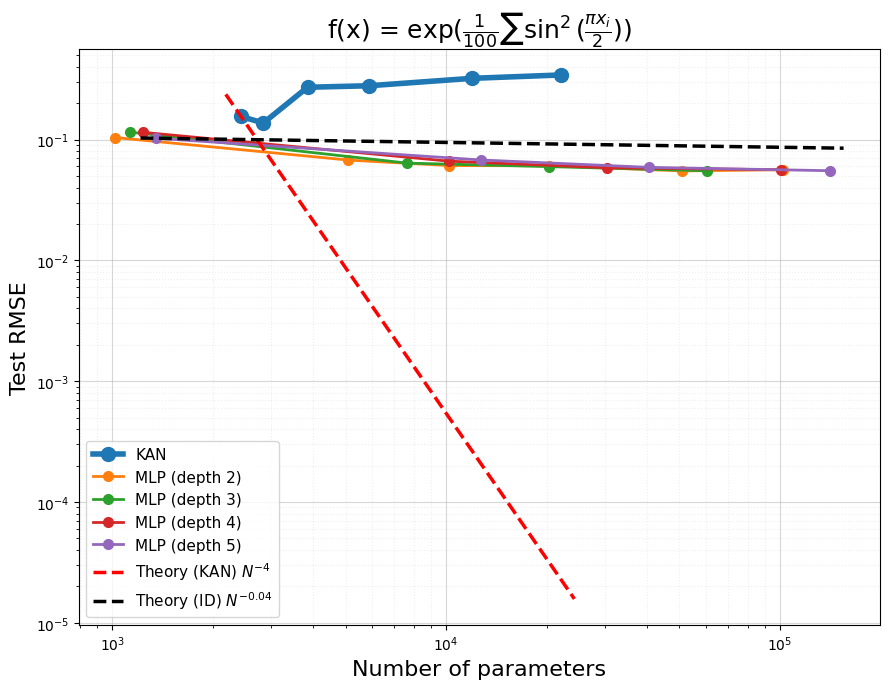

In [12]:
run_experiment(case_id=4)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.59e-02 | test_loss: 1.95e-01 | reg: 1.78e+01 | : 100%|█| 200/200 [00:44<00:00,  4.49


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 1.95e-01
saving model version 0.2


| train_loss: 1.70e-02 | test_loss: 1.93e-01 | reg: 1.74e+01 | : 100%|█| 200/200 [00:44<00:00,  4.49


saving model version 0.3
Case 4 | Grid 5 | Params 2836 | Test RMSE 1.93e-01
saving model version 0.4


| train_loss: 9.79e-05 | test_loss: 3.10e-01 | reg: 1.84e+01 | : 100%|█| 200/200 [00:45<00:00,  4.41


saving model version 0.5
Case 4 | Grid 10 | Params 3846 | Test RMSE 3.10e-01
saving model version 0.6


| train_loss: 2.53e-06 | test_loss: 3.39e-01 | reg: 1.82e+01 | : 100%|█| 200/200 [00:22<00:00,  9.01


saving model version 0.7
Case 4 | Grid 20 | Params 5866 | Test RMSE 3.39e-01
saving model version 0.8


| train_loss: 1.56e-06 | test_loss: 3.73e-01 | reg: 1.82e+01 | : 100%|█| 200/200 [00:28<00:00,  6.93


saving model version 0.9
Case 4 | Grid 50 | Params 11926 | Test RMSE 3.73e-01
saving model version 0.10


| train_loss: 2.76e-06 | test_loss: 3.94e-01 | reg: 1.82e+01 | : 100%|█| 200/200 [00:38<00:00,  5.15


saving model version 0.11
Case 4 | Grid 100 | Params 22026 | Test RMSE 3.94e-01
MLP Depth 2 Width 10 | Params 1021 | Test RMSE 1.04e-01
MLP Depth 2 Width 50 | Params 5101 | Test RMSE 6.76e-02
MLP Depth 2 Width 100 | Params 10201 | Test RMSE 6.09e-02
MLP Depth 2 Width 200 | Params 20401 | Test RMSE 6.06e-02
MLP Depth 2 Width 500 | Params 51001 | Test RMSE 5.50e-02
MLP Depth 2 Width 1000 | Params 102001 | Test RMSE 5.62e-02
MLP Depth 3 Width 10 | Params 1131 | Test RMSE 1.15e-01
MLP Depth 3 Width 50 | Params 7651 | Test RMSE 6.37e-02
MLP Depth 3 Width 100 | Params 20301 | Test RMSE 5.97e-02
MLP Depth 3 Width 200 | Params 60601 | Test RMSE 5.51e-02
Skipping MLP Depth 3 Width 500 (Params 301501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1103001 > 200000)
MLP Depth 4 Width 10 | Params 1241 | Test RMSE 1.15e-01
MLP Depth 4 Width 50 | Params 10201 | Test RMSE 6.62e-02
MLP Depth 4 Width 100 | Params 30401 | Test RMSE 5.84e-02
MLP Depth 4 Width 200 | Params 100801 | Test RMSE 5.62e-02
Sk

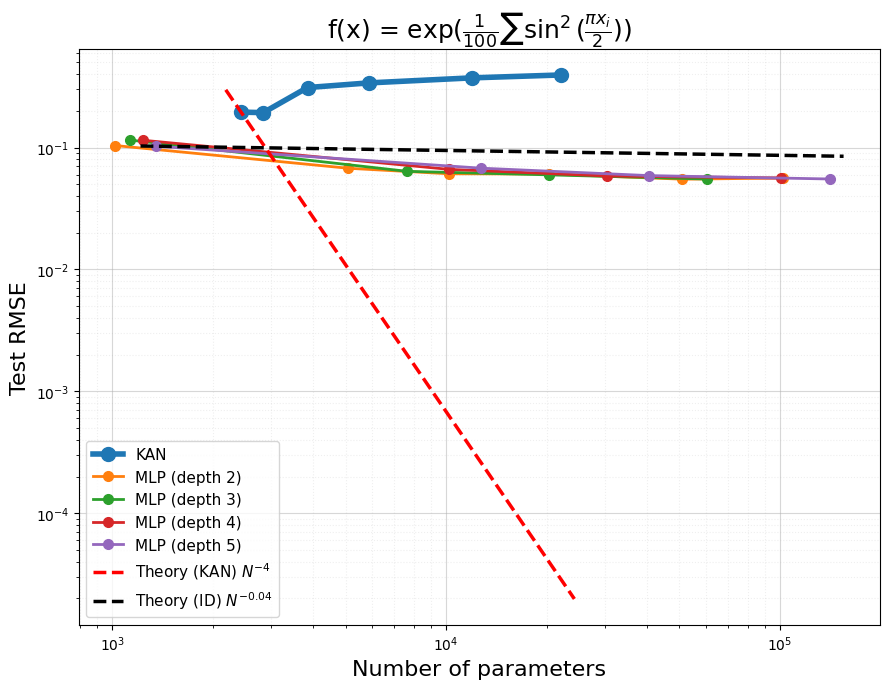

In [13]:
run_experiment(case_id=4)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-02 | test_loss: 1.57e-01 | reg: 1.69e+01 | : 100%|█| 200/200 [00:45<00:00,  4.42


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 1.57e-01
saving model version 0.2


| train_loss: 1.70e-02 | test_loss: 1.38e-01 | reg: 1.72e+01 | : 100%|█| 200/200 [00:45<00:00,  4.42


saving model version 0.3
Case 4 | Grid 5 | Params 2836 | Test RMSE 1.38e-01
saving model version 0.4


| train_loss: 7.94e-04 | test_loss: 2.14e-01 | reg: 1.78e+01 | : 100%|█| 200/200 [00:45<00:00,  4.41


saving model version 0.5
Case 4 | Grid 10 | Params 3846 | Test RMSE 2.14e-01
saving model version 0.6


| train_loss: 3.81e-06 | test_loss: 2.28e-01 | reg: 1.76e+01 | : 100%|█| 200/200 [00:26<00:00,  7.44


saving model version 0.7
Case 4 | Grid 20 | Params 5866 | Test RMSE 2.28e-01
saving model version 0.8


| train_loss: 1.35e-06 | test_loss: 3.02e-01 | reg: 1.76e+01 | : 100%|█| 200/200 [00:19<00:00, 10.12


saving model version 0.9
Case 4 | Grid 50 | Params 11926 | Test RMSE 3.02e-01
saving model version 0.10


| train_loss: 4.61e-06 | test_loss: 3.43e-01 | reg: 1.76e+01 | : 100%|█| 200/200 [00:29<00:00,  6.70


saving model version 0.11
Case 4 | Grid 100 | Params 22026 | Test RMSE 3.43e-01
MLP Depth 2 Width 10 | Params 1021 | Test RMSE 1.04e-01
MLP Depth 2 Width 50 | Params 5101 | Test RMSE 6.76e-02
MLP Depth 2 Width 100 | Params 10201 | Test RMSE 6.09e-02
MLP Depth 2 Width 200 | Params 20401 | Test RMSE 6.06e-02
MLP Depth 2 Width 500 | Params 51001 | Test RMSE 5.50e-02
MLP Depth 2 Width 1000 | Params 102001 | Test RMSE 5.62e-02
MLP Depth 3 Width 10 | Params 1131 | Test RMSE 1.15e-01
MLP Depth 3 Width 50 | Params 7651 | Test RMSE 6.37e-02
MLP Depth 3 Width 100 | Params 20301 | Test RMSE 5.97e-02
MLP Depth 3 Width 200 | Params 60601 | Test RMSE 5.51e-02
Skipping MLP Depth 3 Width 500 (Params 301501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1103001 > 200000)
MLP Depth 4 Width 10 | Params 1241 | Test RMSE 1.15e-01
MLP Depth 4 Width 50 | Params 10201 | Test RMSE 6.62e-02
MLP Depth 4 Width 100 | Params 30401 | Test RMSE 5.84e-02
MLP Depth 4 Width 200 | Params 100801 | Test RMSE 5.62e-02
Sk

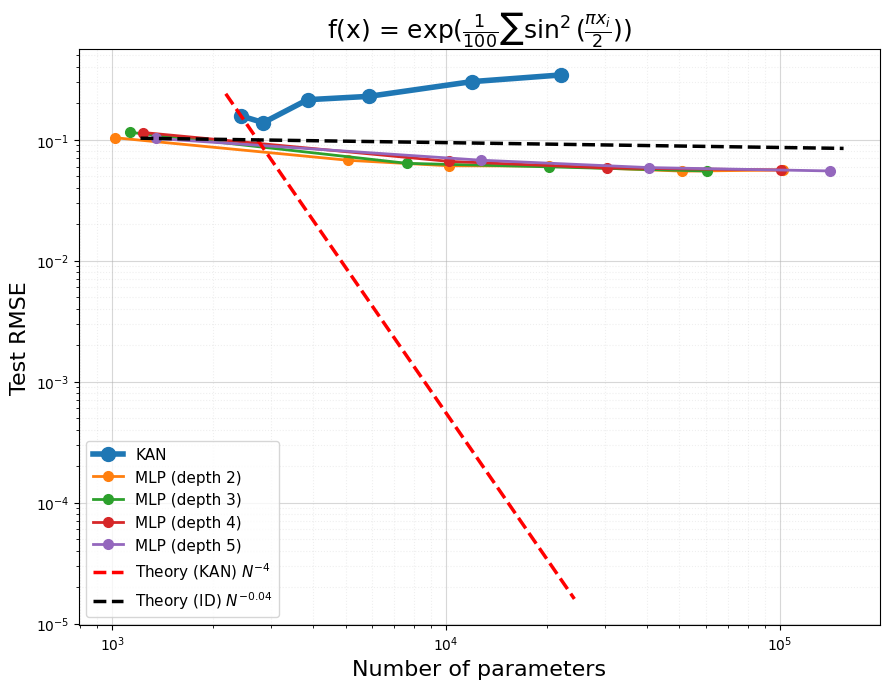

In [14]:
run_experiment(case_id=4)

In [ ]:
run_experiment(case_id=4)

--- Running Case 4 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.57e-02 | test_loss: 1.46e-01 | reg: 1.80e+01 | : 100%|█| 200/200 [00:44<00:00,  4.47


saving model version 0.1
Case 4 | Grid 3 | Params 2432 | Test RMSE 1.46e-01
saving model version 0.2


| train_loss: 1.87e-02 | test_loss: 1.46e-01 | reg: 0.00e+00 | :  42%|▍| 85/200 [00:19<00:26,  4.41i

In [ ]:
run_experiment(case_id=4)

--- Running Case 5 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.10e-01 | test_loss: 1.52e-01 | reg: 1.92e+01 | : 100%|█| 200/200 [00:55<00:00,  3.57


saving model version 0.1
Case 5 | Grid 3 | Params 492 | Test RMSE 1.52e-01
saving model version 0.2


| train_loss: 7.89e-02 | test_loss: 1.22e-01 | reg: 1.93e+01 | : 100%|█| 200/200 [00:55<00:00,  3.61


saving model version 0.3
Case 5 | Grid 5 | Params 564 | Test RMSE 1.22e-01
saving model version 0.4


| train_loss: 5.07e-02 | test_loss: 1.43e-01 | reg: 2.03e+01 | : 100%|█| 200/200 [00:55<00:00,  3.59


saving model version 0.5
Case 5 | Grid 10 | Params 744 | Test RMSE 1.43e-01
saving model version 0.6


| train_loss: 2.83e-02 | test_loss: 1.69e-01 | reg: 2.05e+01 | : 100%|█| 200/200 [00:55<00:00,  3.59


saving model version 0.7
Case 5 | Grid 20 | Params 1104 | Test RMSE 1.69e-01
saving model version 0.8


| train_loss: 4.05e-04 | test_loss: 1.94e-01 | reg: 2.04e+01 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.9
Case 5 | Grid 50 | Params 2184 | Test RMSE 1.94e-01
saving model version 0.10


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [00:56<00:00,  3.54it/s]


saving model version 0.11
Case 5 | Grid 100 | Params 3984 | Test RMSE nan
MLP Depth 2 Width 10 | Params 61 | Test RMSE 4.83e-01
MLP Depth 2 Width 50 | Params 301 | Test RMSE 1.96e-01
MLP Depth 2 Width 100 | Params 601 | Test RMSE 1.94e-01
MLP Depth 2 Width 200 | Params 1201 | Test RMSE 2.26e-01
MLP Depth 2 Width 500 | Params 3001 | Test RMSE 2.36e-01
MLP Depth 2 Width 1000 | Params 6001 | Test RMSE 2.25e-01
MLP Depth 3 Width 10 | Params 171 | Test RMSE 3.10e-01
MLP Depth 3 Width 50 | Params 2851 | Test RMSE 1.69e-01
MLP Depth 3 Width 100 | Params 10701 | Test RMSE 1.72e-01
MLP Depth 3 Width 200 | Params 41401 | Test RMSE 1.28e-01
Skipping MLP Depth 3 Width 500 (Params 253501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1007001 > 200000)
MLP Depth 4 Width 10 | Params 281 | Test RMSE 3.30e-01
MLP Depth 4 Width 50 | Params 5401 | Test RMSE 1.32e-01
MLP Depth 4 Width 100 | Params 20801 | Test RMSE 1.60e-01
MLP Depth 4 Width 200 | Params 81601 | Test RMSE 1.30e-01
Skipping MLP Depth 4 

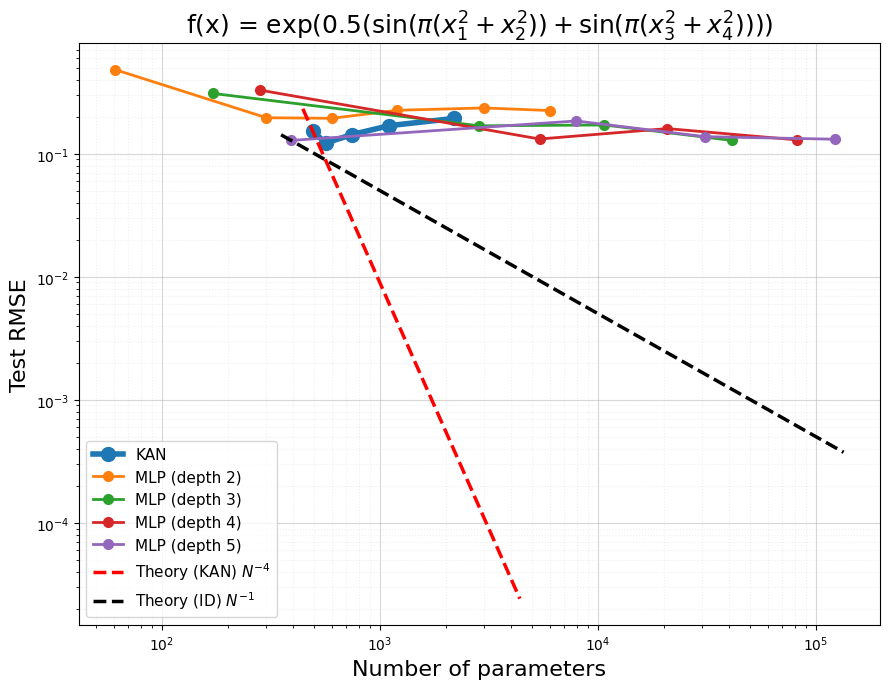

In [38]:
run_experiment(case_id=5)

--- Running Case 5 ---
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.20e-02 | test_loss: 1.88e-02 | reg: 1.94e+01 | : 100%|█| 200/200 [00:56<00:00,  3.54


saving model version 0.1
Case 5 | Grid 3 | Params 492 | Test RMSE 1.88e-02
saving model version 0.2


| train_loss: 9.66e-03 | test_loss: 4.55e-02 | reg: 1.85e+01 | : 100%|█| 200/200 [00:56<00:00,  3.53


saving model version 0.3
Case 5 | Grid 5 | Params 564 | Test RMSE 4.55e-02
saving model version 0.4


| train_loss: 4.90e-03 | test_loss: 4.02e-02 | reg: 1.91e+01 | : 100%|█| 200/200 [00:57<00:00,  3.51


saving model version 0.5
Case 5 | Grid 10 | Params 744 | Test RMSE 4.02e-02
saving model version 0.6


| train_loss: 3.14e-03 | test_loss: 4.34e-02 | reg: 1.92e+01 | : 100%|█| 200/200 [00:35<00:00,  5.56


saving model version 0.7
Case 5 | Grid 20 | Params 1104 | Test RMSE 4.34e-02
saving model version 0.8


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [00:56<00:00,  3.56it/s]


saving model version 0.9
Case 5 | Grid 50 | Params 2184 | Test RMSE nan
saving model version 0.10


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [00:56<00:00,  3.55it/s]


saving model version 0.11
Case 5 | Grid 100 | Params 3984 | Test RMSE nan
MLP Depth 2 Width 10 | Params 61 | Test RMSE 4.83e-01
MLP Depth 2 Width 50 | Params 301 | Test RMSE 1.96e-01
MLP Depth 2 Width 100 | Params 601 | Test RMSE 1.94e-01
MLP Depth 2 Width 200 | Params 1201 | Test RMSE 2.26e-01
MLP Depth 2 Width 500 | Params 3001 | Test RMSE 2.36e-01
MLP Depth 2 Width 1000 | Params 6001 | Test RMSE 2.25e-01
MLP Depth 3 Width 10 | Params 171 | Test RMSE 3.10e-01
MLP Depth 3 Width 50 | Params 2851 | Test RMSE 1.69e-01
MLP Depth 3 Width 100 | Params 10701 | Test RMSE 1.72e-01
MLP Depth 3 Width 200 | Params 41401 | Test RMSE 1.28e-01
Skipping MLP Depth 3 Width 500 (Params 253501 > 200000)
Skipping MLP Depth 3 Width 1000 (Params 1007001 > 200000)
MLP Depth 4 Width 10 | Params 281 | Test RMSE 3.30e-01
MLP Depth 4 Width 50 | Params 5401 | Test RMSE 1.32e-01
MLP Depth 4 Width 100 | Params 20801 | Test RMSE 1.60e-01
MLP Depth 4 Width 200 | Params 81601 | Test RMSE 1.30e-01
Skipping MLP Depth 4 

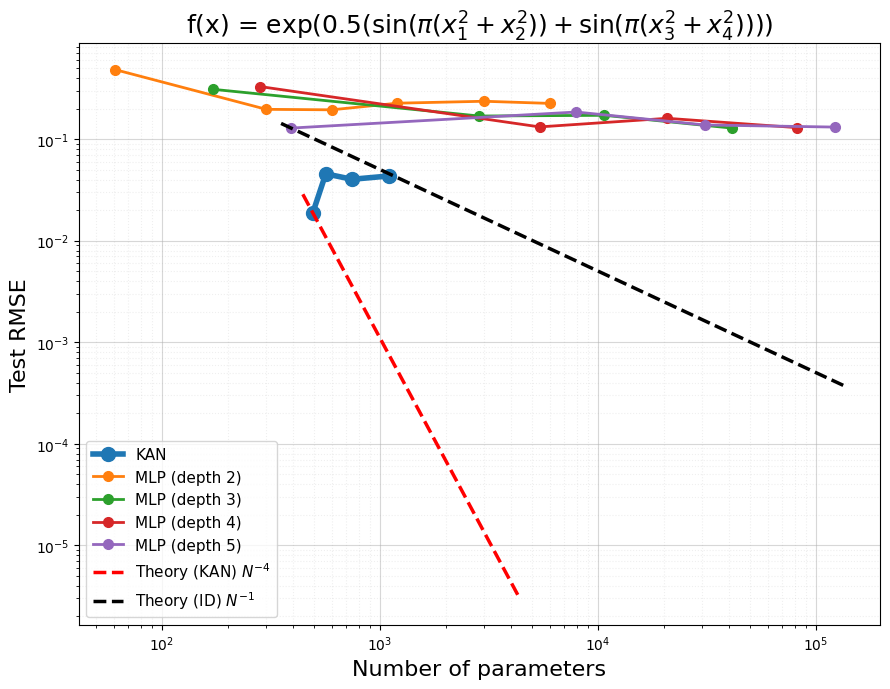

In [32]:
run_experiment(case_id=5)